In [2]:
import mne, mne_bids
mne.set_config('MNE_BROWSER_BACKEND', 'matplotlib') # To plot in the notebook using matplotlib
import sys
sys.path.insert(0, '.')
import ccs_eeg_utils

%matplotlib inline

Attempting to create new mne-python configuration file:
/Users/edward/.mne/mne-python.json
Using matplotlib as 2D backend.


In [8]:
from mne_bids import BIDSPath, read_raw_bids

# path where to save the datasets.
bids_root = "../../../../Datasets/project-dataset//"
subject_id = '01' #


bids_path = BIDSPath(subject=subject_id,task="run5",
                     datatype='eeg', suffix='eeg',
                     root=bids_root)

In [ ]:
# read the file
raw = read_raw_bids(bids_path)
# fix the annotations readin
ccs_eeg_utils.read_annotations_core(bids_path,raw)
raw.load_data()
raw.set_eeg_reference("average")
raw.set_montage('standard_1020',match_case=False)


In [5]:
# Let's downsample to 200Hz to speed up calculations
raw_downsampled = raw_f.resample(200)

In [6]:
# Break raw data into 1 s epochs
tstep = 1
events_ica = mne.make_fixed_length_events(raw_downsampled, duration=tstep)
epochs_ica = mne.Epochs(raw_downsampled, events_ica,
                        tmin=0.0, tmax=tstep,
                        baseline=None,
                        preload=True)

Not setting metadata
539 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 539 events and 201 original time points ...
1 bad epochs dropped


In [7]:
# Finding bad epochs using autoreject

from autoreject import AutoReject

ar = AutoReject(n_interpolate=[1, 2, 4],
                random_state=42,
                picks=mne.pick_types(epochs_ica.info, 
                                     eeg=True,
                                     eog=False
                                    ),
                n_jobs=-1, 
                verbose=False
                )

ar.fit(epochs_ica)
reject_log = ar.get_reject_log(epochs_ica)


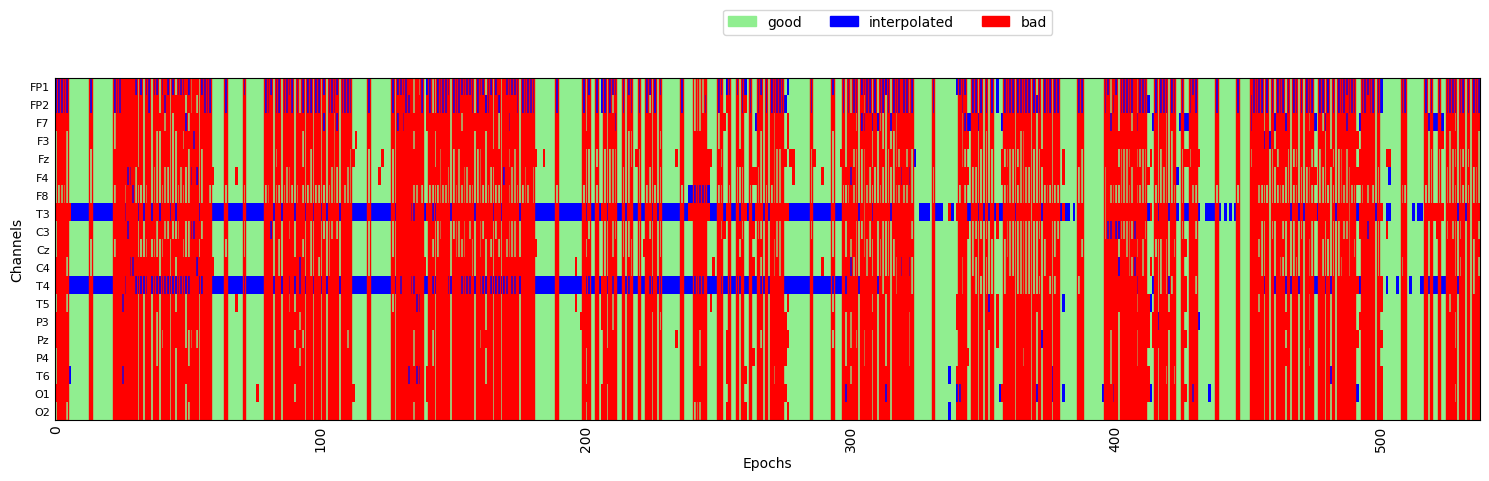

In [8]:
# Plotting rejected epochs
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=[15, 5])
reject_log.plot('horizontal', ax=ax, aspect='auto')
plt.show()

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 14 components
Computing Extended Infomax ICA
Fitting ICA took 4.4s.


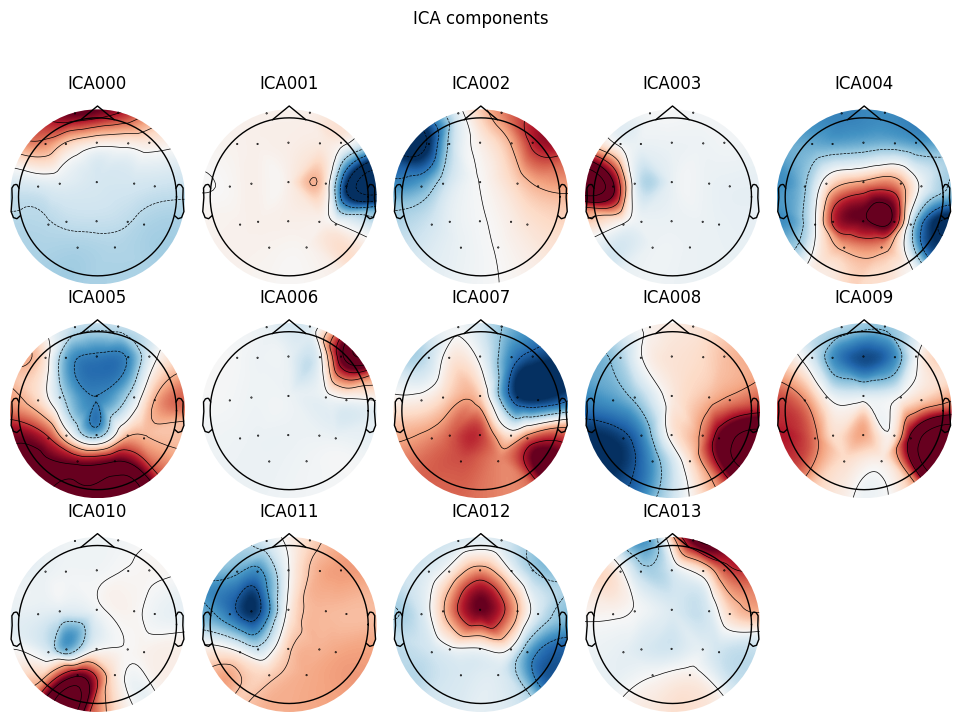

In [ ]:
# ICA parameters
random_state = 42   # ensures ICA is reproducible each time it's run
ica_n_components = .99     # Specify n_components as a decimal to set % explained variance

# Fit ICA
ica = mne.preprocessing.ICA(n_components=ica_n_components,
                            random_state=random_state,
                            # method='picard',
                            method = 'infomax',
                            fit_params=dict(extended=True)
                            )
ica.fit(epochs_ica[~reject_log.bad_epochs], decim=3)

ica.plot_components();
# plot the ica sources
ica.plot_sources(raw_f, show_scrollbars=False, start = 30, stop = 40);
# Auto generate labels from the ICA sources 
from mne_icalabel import label_components

ic_labels = label_components(raw_downsampled, ica, method="iclabel")

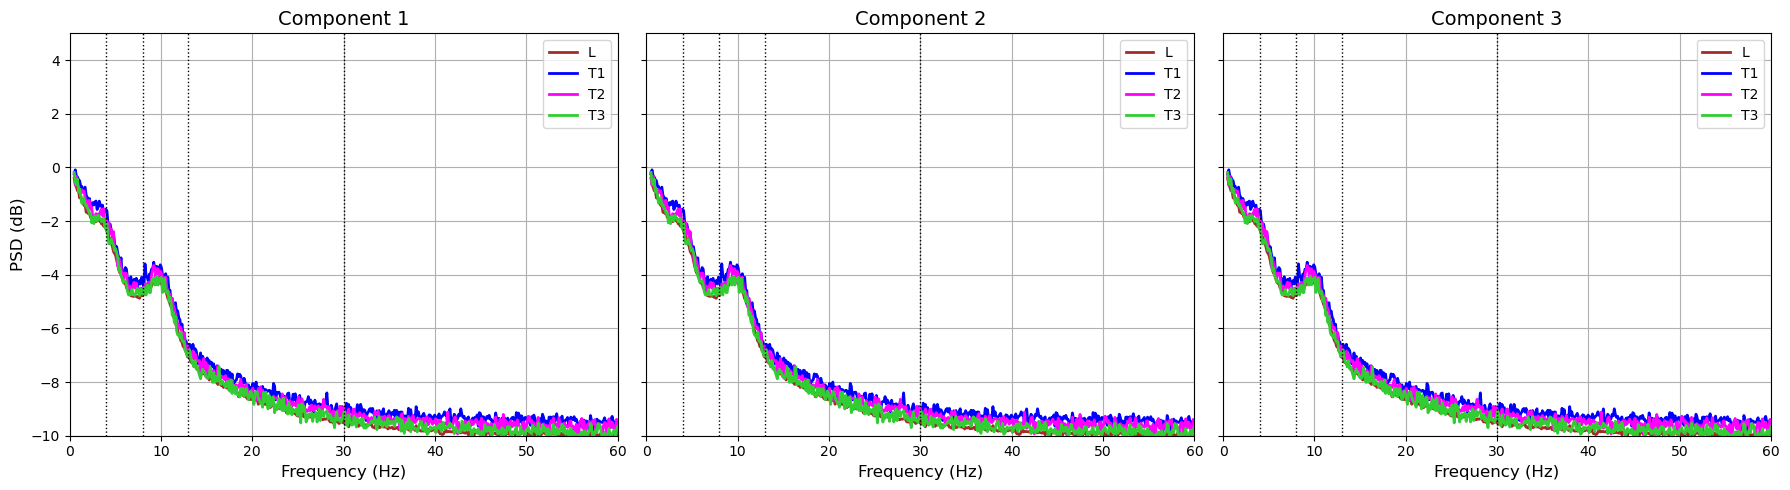

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

frequencies = np.linspace(0.5, 60, 500)
def simulate_psd(offset=0.0, noise_level=0.15):
    psd = -10 + 10 * np.exp(-frequencies / 10)  
    psd += 2 * np.exp(-((frequencies - 10) ** 2) / 4)  
    psd += 1 * np.exp(-((frequencies - 4) ** 2) / 2)  
    noise = np.random.normal(scale=noise_level, size=frequencies.shape)
    return psd + offset + noise


data = [L, T1, T2, T3]
labels = ['L', 'T1', 'T2', 'T3']
colors = ['brown', 'blue', 'magenta', 'limegreen']

fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, ax in enumerate(axs):
    for j, psd in enumerate(data):
        ax.plot(frequencies, psd, label=labels[j], color=colors[j], linewidth=2)
    
    ax.set_title(f'Component {i + 1}', fontsize=14)
    ax.set_xlabel('Frequency (Hz)', fontsize=12)
    if i == 0:
        ax.set_ylabel('PSD (dB)', fontsize=12)
        
    ax.set_xlim(0, 60)
    ax.set_ylim(-10, 5)
    ax.grid(True)

    for freq in [4, 8, 13, 30]:
        ax.axvline(x=freq, color='k', linestyle='dotted', linewidth=1)
    
    ax.legend()

plt.tight_layout()
plt.show()


In [14]:
# Exclude the non brain and other sources

labels = ic_labels["labels"]
exclude_idx = [idx for idx, label in enumerate(labels) if label not in ["brain", "other"]]
print(f"Excluding these ICA components: {exclude_idx}")
ica.exclude = exclude_idx

Excluding these ICA components: [0, 1, 2, 3, 5, 9, 10, 12, 13]


In [ ]:
# Plot the ICA removed data on the raw data
ica.plot_overlay(raw_downsampled,exclude=exclude_idx);

In [ ]:
reconst_raw = raw_downsampled.copy()
ica.apply(reconst_raw, exclude=exclude_idx)
reconst_raw.filter(1, 40, fir_design='firwin')